In [34]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)
import statsmodels.api as sm
import seaborn as sns

In [35]:
df = pd.read_csv(r"C:\Users\Acer\Downloads\Test.csv - test.csv")

In [37]:
# as the idea is to minimize the distance between upfront and metered price, we need to analyse the rows of data for which we have both columns different from null
df = df.dropna(subset=['upfront_price','metered_price'])

# we want to understand the behavior of the most basic model in the ride-hailing business; therefore, we only consider cases where dest_change_number = 1

df = df[df.change_reason_pricing.isnull()]

# add variable to measure relationship between upfront and metered price

df['price_quo'] = df['upfront_price'] / df['metered_price']

# add boolean to determine if metered price is within +/- 20% of the upfront price

df['paid_metered'] = np.where(df['price_quo'] > 1.2, 1, np.where(df['price_quo'] < 0.8, 1, 0))

# add two variables: absolute difference between distance and duration, and its predicted counterparts

df['abs_diff_distance'] = abs(df['distance'] - df['predicted_distance']) / 100 # we divide by 100 simply to make the ensuing coefficient more legible
df['abs_diff_duration'] = abs(df['duration'] - df['predicted_duration']) / 100 # we divide by 100 simply to make the ensuing coefficient more legible

# working off the premise that app version might affect prediction performance, we create two dummies to determine whether the driver and rider are using a DA and CA version of the app respectively.

df['is_da'] = np.where(df['driver_app_version'].str[0:2] == 'DA', 1, 0)
df['is_ca'] = np.where(df['rider_app_version'].str[0:2] == 'CA', 1, 0)

# the elimination of outliers can give us better insights into how the core business is run; further analysis may provide a way to cut down on outliers themselves
# as the relevant variable is the price_quo relationship between upfront and metered price, we will be using it for outlier detection
# we remove only those values whose price_quo variable is 3 standard deviations from the mean

df = df[(np.abs(stats.zscore(df['price_quo'])) < 3)]

# we make an alteration to the duration and distance variables so their coefficients are more legible

df['duration'] = df['duration']/100
df['distance'] = df['distance']/100

df['predicted_duration'] = df['predicted_duration']/100
df['predicted_distance'] = df['predicted_distance']/100

Total number of rides:  3334
Total number of rides paid with metered:  1295
Rides not within 20% range:  38.84%


Rides with prediction above 20% of metered:  361
Rides with prediction above metered:  1186
Rides with prediction below 20% of metered:  934
Rides with prediction below metered:  1973
Rides with exact prediction:  175


Average overall prediction/metered : 0.9663
Median overall prediction/metered : 0.9541


array([[<AxesSubplot:title={'center':'price_quo'}>]], dtype=object)

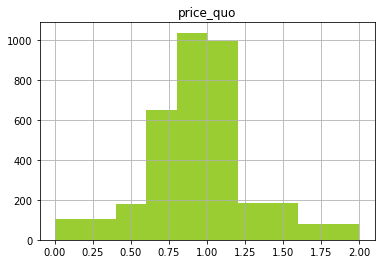

In [38]:
# this leaves us with an initial dataframe with the following basic characteristics


ride = (df[df.paid_metered == 1].shape[0]/df.shape[0])
prediction_higher_20 = df[(df.price_quo > 1) & (df.paid_metered == 1)].shape[0]
prediction_higher = df[df.price_quo > 1].shape[0]
prediction_lower_20 = df[(df.price_quo < 1) & (df.paid_metered == 1)].shape[0]
prediction_lower = df[df.price_quo < 1].shape[0]
prediction_correct = df[df.price_quo == 1].shape[0]
price_q = np.mean(df.price_quo)
price_median = np.median(df.price_quo)


print ('Total number of rides: ',df.shape[0])
print ('Total number of rides paid with metered: ',df[df.paid_metered == 1].shape[0])
print ('Rides not within 20% range: ',"{:.2%}".format(ride))
print("\n")

print ('Rides with prediction above 20% of metered: ',prediction_higher_20)
print ('Rides with prediction above metered: ',prediction_higher)
print ('Rides with prediction below 20% of metered: ',prediction_lower_20)
print ('Rides with prediction below metered: ',prediction_lower)
print ('Rides with exact prediction: ',prediction_correct)
print("\n")

print('Average overall prediction/metered :', "{:.4}".format(price_q))
print('Median overall prediction/metered :', "{:.4}".format(price_median))

df.hist(column = 'price_quo', color = 'yellowgreen', bins = [0, 0.4, 0.6, 0.8, 1, 1.2, 1.6, 2])

In [39]:
# we define a couple of variables to explore the relationships between EU variable and duration and distance

df['eu_predicted_duration'] = df['eu_indicator'] * df['predicted_duration']
df['eu_predicted_distance'] = df['eu_indicator'] * df['predicted_distance']

df['eu_abs_diff_duration'] = df['eu_indicator'] * df['abs_diff_duration']
df['eu_abs_diff_distance'] = df['eu_indicator'] * df['abs_diff_distance']


In [40]:

# the variables below are those considered relevant to the prediction of whether the measured price will be paid at the ride's end
x_train = df[['abs_diff_distance','abs_diff_duration','eu_indicator','is_da','is_ca','gps_confidence','predicted_distance','predicted_duration','overpaid_ride_ticket','eu_predicted_duration','eu_predicted_distance','eu_abs_diff_duration','eu_abs_diff_distance']]
y_train = df[['paid_metered']]

x1 = sm.add_constant(x_train)

logit_model = sm.Logit(y_train, x1).fit()

Optimization terminated successfully.
         Current function value: 0.286421
         Iterations 10


In [41]:
x_test = df[['abs_diff_distance','abs_diff_duration','eu_indicator','is_da','is_ca','gps_confidence','predicted_distance','predicted_duration','overpaid_ride_ticket','eu_predicted_duration','eu_predicted_distance','eu_abs_diff_duration','eu_abs_diff_distance']]
y_test = df[['paid_metered']]

x2 = sm.add_constant(x_test)

yhat = logit_model.predict(x2)
prediction = list(map(round, yhat))

Text(0.5, 257.44, 'Predicted label')

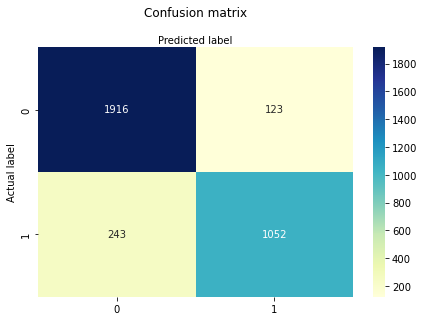

In [42]:

  
# a confusion matrix is used to visualize the success and failed rate of prediction for a model.

cm = confusion_matrix(y_test, prediction) 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [43]:
# the reported 89% accuracy for the model is above the 80% threshold considered to determine an accurate model

print('Test accuracy = ', accuracy_score(y_test, prediction))

# therefore, this model can be reliably used to determine if a ride will be paid according to the metered price, under the aforementioned simplified premises for a 'basic' ride-hailing business

Test accuracy =  0.8902219556088782


In [44]:
print(logit_model.summary())

                           Logit Regression Results                           
Dep. Variable:           paid_metered   No. Observations:                 3334
Model:                          Logit   Df Residuals:                     3320
Method:                           MLE   Df Model:                           13
Date:                Wed, 24 Aug 2022   Pseudo R-squ.:                  0.5713
Time:                        12:23:27   Log-Likelihood:                -954.93
converged:                       True   LL-Null:                       -2227.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.4594      0.471     -7.344      0.000      -4.383      -2.536
abs_diff_distance         0.1262      0.011     11.244      0.000       0.104       0.148
abs_diff